# Example code of Single-slice ptychography 



Import all of the rquired packages.
abTEM used to simulate the 4D-data.
ase used to read and view the catalyst model.

In [1]:
import abtem
import py4DSTEM

import matplotlib.pyplot as plt
import numpy as np

from ase.io import read
from ase.visualize import view


In [2]:
atoms = read(r"C:\Users\Joshu\Documents\Python Scripts\General_TEM_simulation\rotated_to_perfection.cfg")
view (atoms)

<Popen: returncode: None args: ['C:\\Users\\Joshu\\anaconda3\\envs\\myenv\\p...>

# abTEM pixelated detector

We create the potential and probe that will be used to simulate the 4D-dataset. Additionally, the probe is defocused by 150 angstroms at a semi-angle of 20mrad providing a probe of around 6angstroms (this is very low).
Note: Frozen-phonons are not used in this simulation.

[########################################] | 100% Completed | 2.09 ss
[########################################] | 100% Completed | 111.54 ms


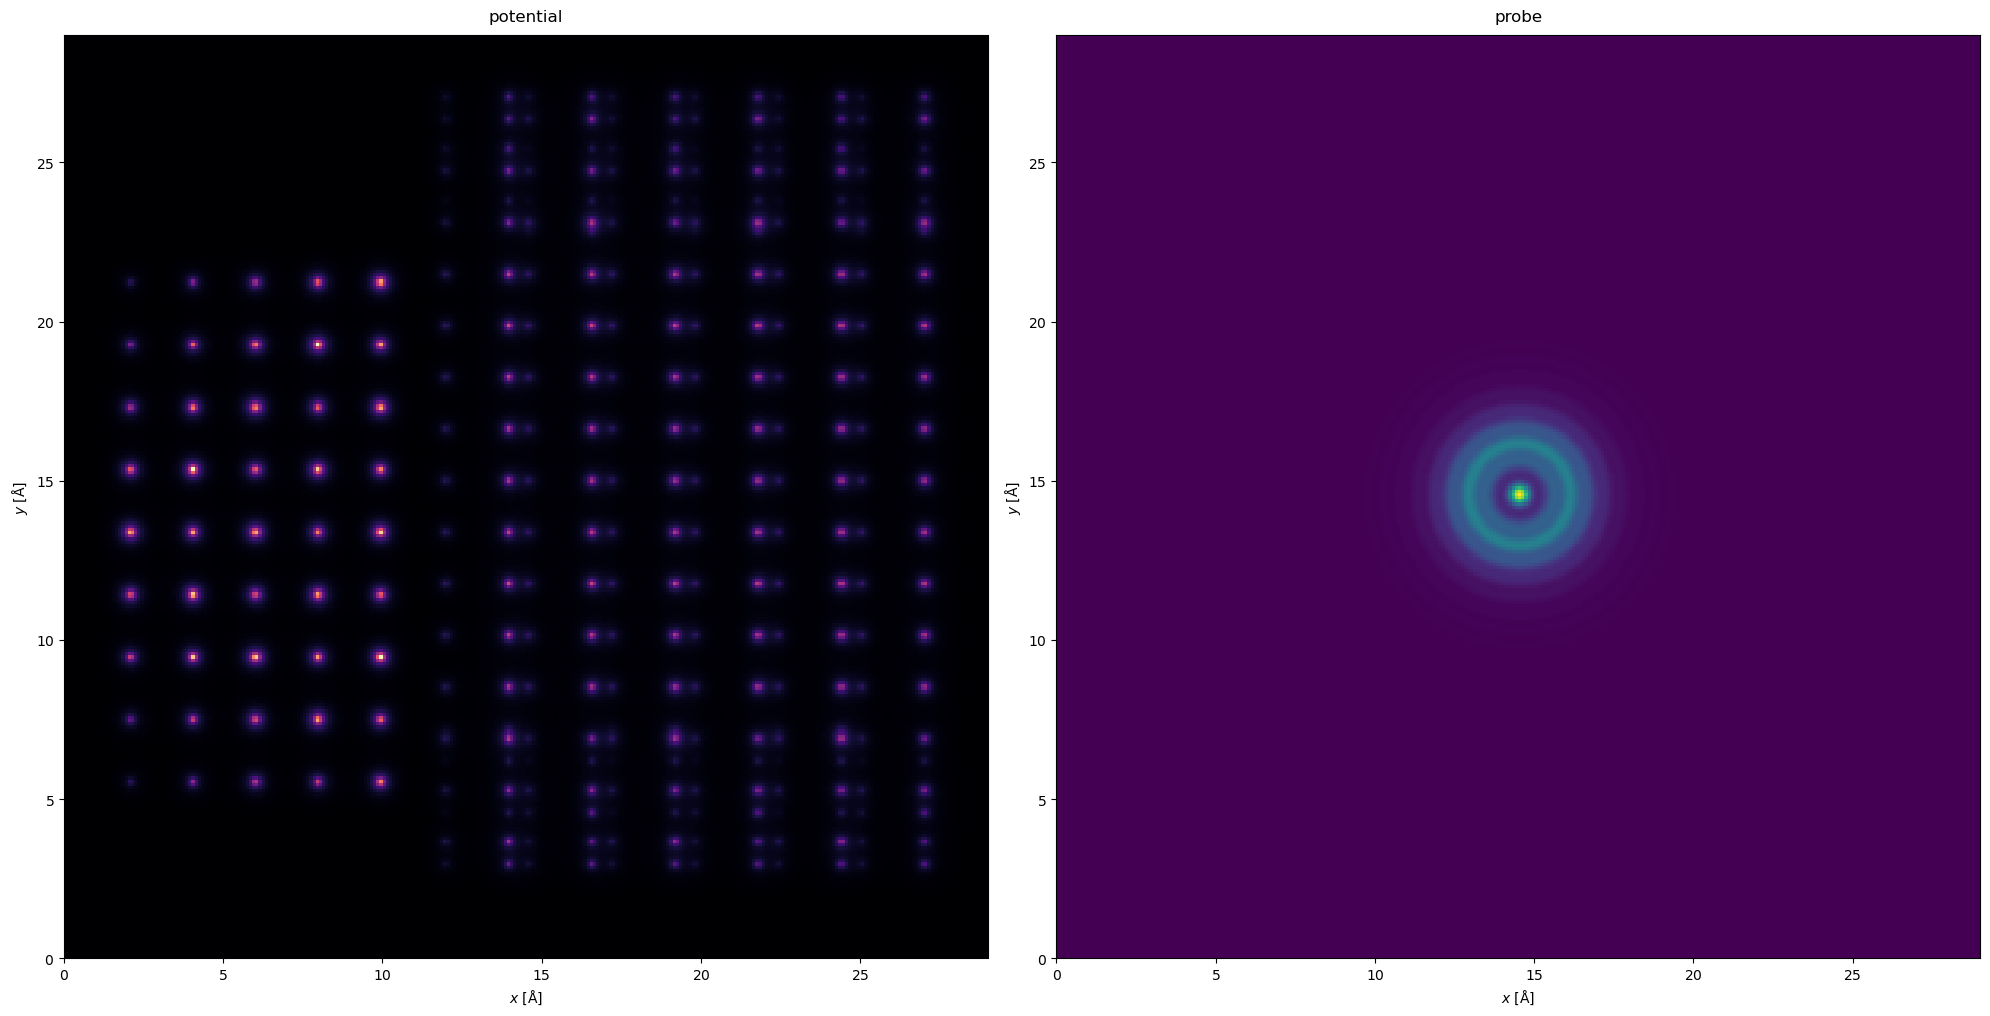

In [3]:
energy = 300e3 # volts
semiangle_cutoff = 20 # mrad
defocus = 150 # ang


potential = abtem.Potential(
    atoms,
    sampling=0.1,
    device="gpu",
    projection="infinite",
    parametrization="lobato",
)

probe = abtem.Probe(
    semiangle_cutoff=semiangle_cutoff,
    energy=energy,
    defocus=defocus,
    device="gpu"
)
probe.match_grid(potential)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

potential.show(ax=ax1,cmap='magma', title="potential")
probe.show(ax=ax2, title="probe")
fig.tight_layout()


Following the method in the py4DSTEM tutorial we cset-up the grid scan with number of pixels in our detector and step size in angstroms.
Link to tutorial
https://github.com/py4dstem/py4DSTEM_tutorials/blob/main/notebooks/version_0.14.8/ptycho00_dangerous-to-go-alone.ipynb

After setting up gridscan we apply shot noise/Poisson noise to simulate dose limitation.

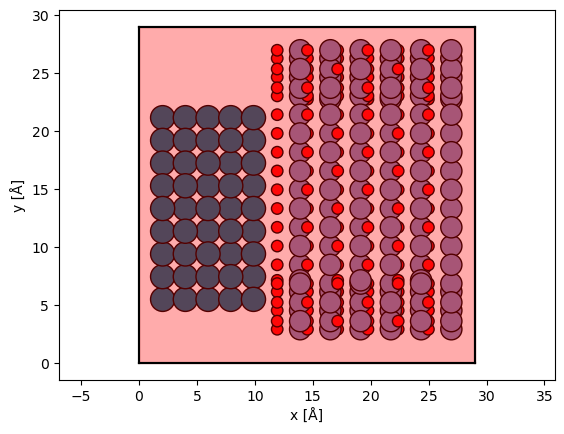

In [4]:
num_detector_pixels = 256# px
maximum_scattering_angle_mrad = 80 # mrad
scan_step_size = 0.8 # ang

resample = 2*maximum_scattering_angle_mrad/num_detector_pixels
pixelated_detector = abtem.PixelatedDetector(
    max_angle=maximum_scattering_angle_mrad*0.975,
    resample=(resample,resample)
)

gridscan = abtem.GridScan(
    (0,0),
    potential.extent,
    sampling=scan_step_size,
    endpoint=True
)

measurement = probe.scan(scan=gridscan, detectors=pixelated_detector, potential=potential)

fig, ax = abtem.show_atoms(atoms)
gridscan.add_to_plot(ax)

[########################################] | 100% Completed | 6.56 ss


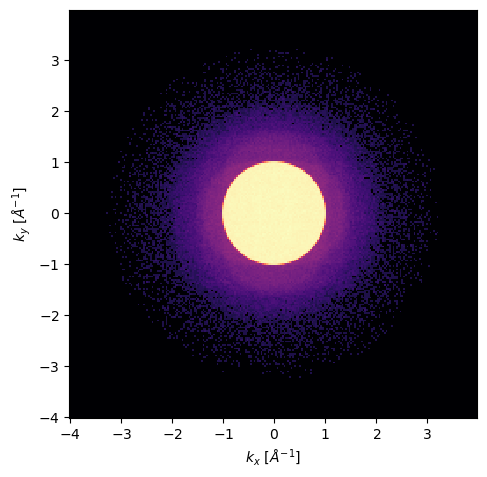

In [5]:
electron_dose = 1e4 # e/A^2

measurement_noise = measurement.poisson_noise(electron_dose)
measurement_noise.mean((0,1)).show(power=0.25,cmap='magma');

# Ptychography

The data is calibrate and I believe turned into a datacube for the py4DSTEM to be able to perform the ptychography.
After this step the parameters that were used to simulate the 4D-dataset are expressed here for the reconstruction.

In [6]:
raw_datacube = py4DSTEM.DataCube(measurement_noise.array)
raw_datacube.calibration.set_Q_pixel_size(2*maximum_scattering_angle_mrad/num_detector_pixels)
raw_datacube.calibration.set_Q_pixel_units('mrad')
raw_datacube.calibration.set_R_pixel_size(scan_step_size)
raw_datacube.calibration.set_R_pixel_units('A')
raw_datacube.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.625
             R_pixel_size:    0.8
             Q_pixel_units:   mrad
             R_pixel_units:   A
             QR_flip:         False
)

Reconstructing object and probe: 100%|████████████████████████████████████████████| 300/300 [16:42<00:00,  3.34s/ iter]


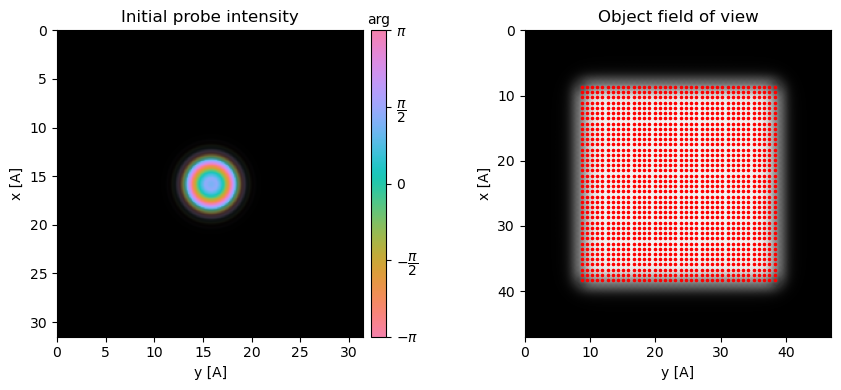

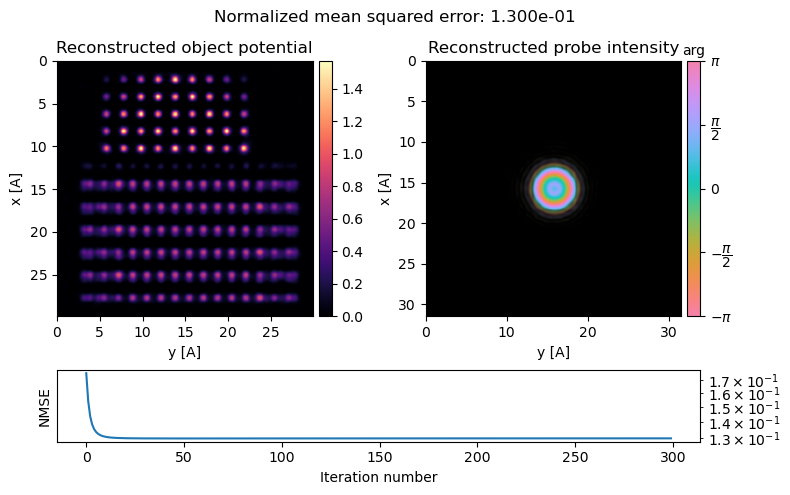

In [7]:
ptycho = py4DSTEM.process.phase.SingleslicePtychographicReconstruction(
    datacube=raw_datacube,
    verbose=False,
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    defocus=defocus,
    device='gpu',
    object_padding_px=(num_detector_pixels//4,)*2,
    object_type='potential',
).preprocess(
    force_com_rotation=0,
    force_com_transpose=False,
    plot_rotation=False,
    plot_center_of_mass = False,
)


ptycho = ptycho.reconstruct(
    max_iter = 300,
    step_size=0.4,
    reset=True,
).visualize()


#plt.savefig('Ptycho_ZnO.png')